## Setup and data source

In [6]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [7]:
from tsai.all import *
my_setup()

os              : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
python          : 3.7.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.1+cu113
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


In [8]:
def load_stock_price_dataset(symbol):
    return pd.read_csv(
            f"/content/{symbol.lower()}.us.txt", 
            index_col='datetime', 
            parse_dates={'datetime': ['<DATE>', '<TIME>']},
            usecols=['<DATE>', '<TIME>', '<CLOSE>'], 
            na_values=['nan']
    ).rename(columns={'<CLOSE>': 'price'})   

In [67]:
SYMBOL = 'META'
df = load_stock_price_dataset(SYMBOL)
df.head()

,price
datetime,
2022-01-25 16:00:00,299.4400
2022-01-25 17:00:00,301.5590
2022-01-25 18:00:00,299.1200
2022-01-25 19:00:00,301.3400
2022-01-25 20:00:00,304.5000
...,...
2022-11-21 18:00:00,110.1200
2022-11-21 19:00:00,109.3176
2022-11-21 20:00:00,110.3700


In [68]:
# df['diff'] = df.price.diff()
# df

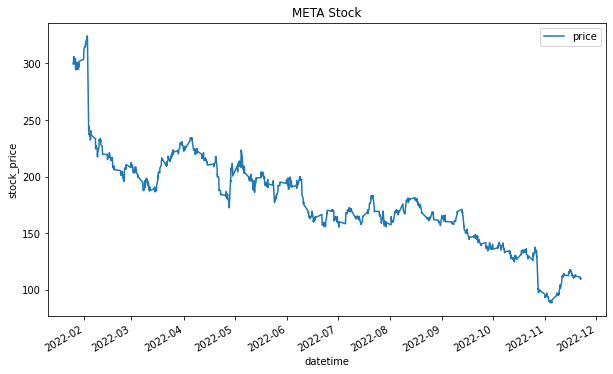

In [61]:
df.plot(figsize=(10, 6), subplots=True);
plt.ylabel("stock_price")
plt.title(f"{SYMBOL} Stock");

## Prepare data 

In [69]:
config = dict(
    data = dict(
        look_back=60,
    ),
    model=dict(
        input_dim = 1,
        hidden_dim = 32,
        num_layers = 2,
        output_dim = 1,
    ),
    inference=dict(
    )
)

In [106]:
import datetime

def split_time_series(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    return df[:cutoff_datetime].copy(), df[cutoff_datetime:].copy()

In [107]:
import datetime

def get_splits(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    indices = np.arange(len(df))
    return indices[df.index < cutoff_datetime].tolist(), indices[df.index >= cutoff_datetime].tolist()

In [108]:
# function to create train, test data given stock data and sequence length
def load_data(df, look_back):
    data_raw = df.values # convert to numpy array
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    x = np.swapaxes(data[:,:-1],1,2)
    y = data[:,-1,:]
    return x, y

In [109]:
splits = get_splits(df.iloc[:-60], '2022-10-01')
len(splits[0]), len(splits[1]), len(splits[1]) / len(splits[0])

(1211, 192, 0.15854665565648224)

X      - shape: [1403 samples x 1 features x 59 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1403, 1)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1211, 192]  overlap: False


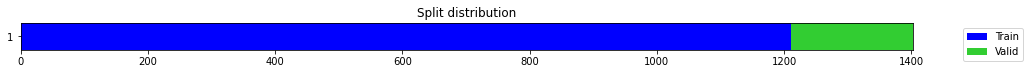

In [110]:
look_back = config['data']['look_back'] # choose sequence length
X, y = load_data(df, look_back)
check_data(X, y, splits)

In [111]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:128, vars:1, len:59, device=cpu, dtype=torch.float32),
 tensor([[168.8850],
         [154.9550],
         [190.3500],
         [211.3950],
         [183.7800],
         [150.8500],
         [160.6400],
         [215.4600],
         [194.4300],
         [204.7250],
         [156.2800],
         [156.5500],
         [168.2800],
         [190.7300],
         [150.2062],
         [197.0560],
         [174.5500],
         [179.0500],
         [196.2300],
         [214.0000],
         [208.8500],
         [137.5050],
         [233.7200],
         [190.8500],
         [213.9250],
         [189.0500],
         [168.3200],
         [169.2700],
         [162.0600],
         [177.3950],
         [161.4500],
         [190.7050],
         [170.8800],
         [164.4350],
         [174.8509],
         [196.5900],
         [203.7700],
         [196.1900],
         [214.7010],
         [159.1500],
         [229.0000],
         [200.0800],
         [159.1700],
         [184.1100],
   

`TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [112]:
dls.c

1

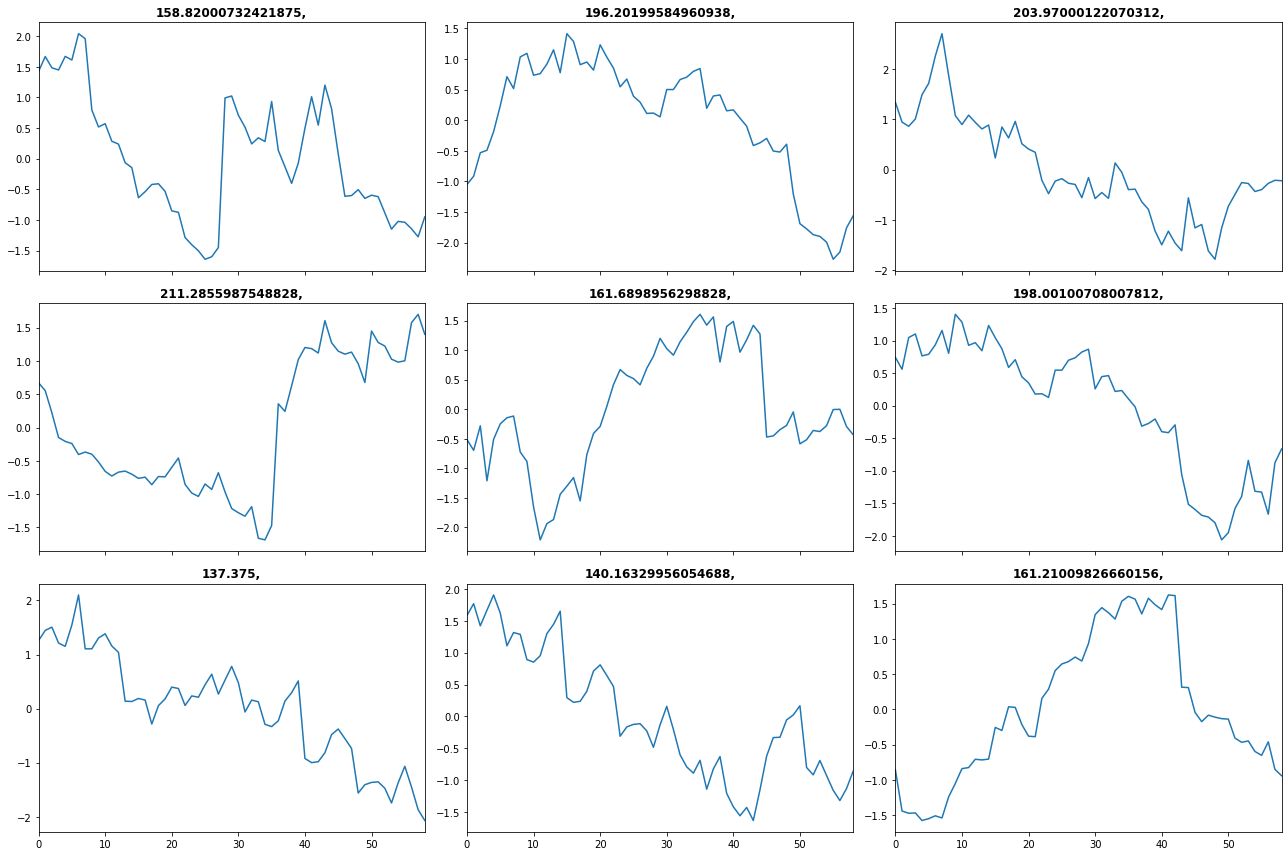

In [113]:
dls.show_batch()

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

In [127]:
batch_tfms = TSStandardize(by_sample=True, by_var=True)
learn = TSRegressor(
    X, y, 
    splits=splits, 
    batch_tfms=batch_tfms, 
    arch=None, 
    metrics=[rmse, mape], 
    bs=128, 
    train_metrics=True, 
    cbs=ShowGraphCallback2()
)

In [128]:
learn.loss_func

FlattenedLoss of MSELoss()

In [ ]:
# learn.lr_find()

## Train model 🚵🏼‍

epoch,train_loss,train__rmse,train_mape,valid_loss,valid__rmse,valid_mape,time
0,31977.267578,179.070023,0.966203,12260.575195,110.727478,0.968608,00:10
1,24545.601562,136.513443,0.717945,6179.544434,78.610077,0.672150,00:12
2,15767.475586,49.395290,0.216145,19071.322266,138.098953,1.229650,00:10
3,10881.975586,24.145308,0.114045,6881.920410,82.957344,0.711954,00:10


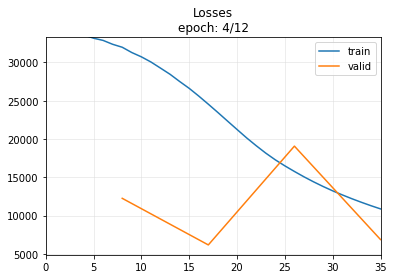

In [ ]:
learn.fit_one_cycle(12, 3e-3)

In [57]:
PATH = Path('./models/meta-inception.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [58]:
del learn

## Inference ⎘

We'll now upload the saved learner and create the predictions:

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [99]:
def visualize_predictions(dates, y, preds):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    
    axes.plot(dates, y, color = 'red', label = 'Real Stock Price')
    axes.plot(dates, preds, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{SYMBOL} Stock Price')
    plt.legend()
    plt.show()
    
    score_mape = mean_absolute_percentage_error(y, preds)
    print(f"MAPE: {score_mape:.2%}")

Baseline - Moving Average - Validation set


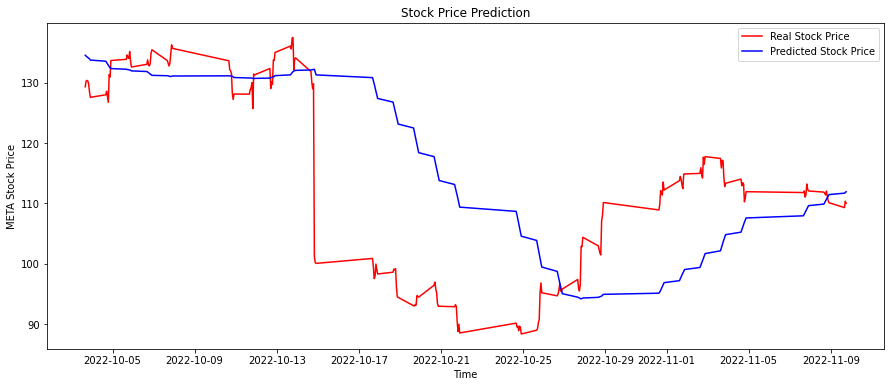

MAPE: 9.92%


In [100]:
def baseline_sma(x):
    return x.mean(axis=-1)

print("Baseline - Moving Average - Validation set")
print("="*32)

split = splits[1]
dates = df.iloc[split].index
preds = baseline_sma(X[split])
visualize_predictions(dates, y[split], preds)

Baseline - Naive Forecast - Validation set


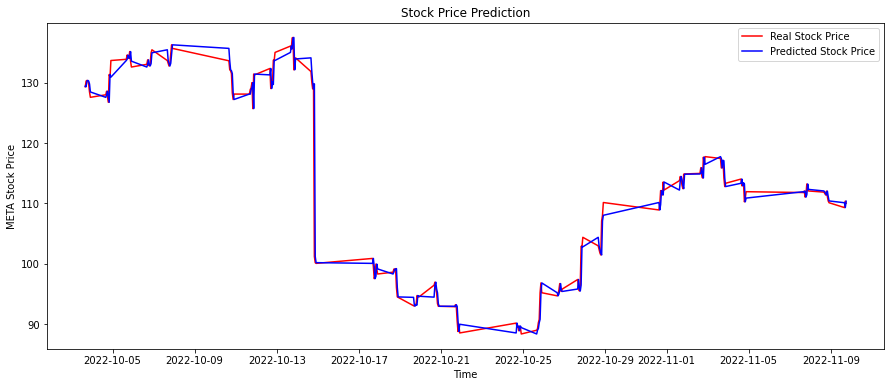

MAPE: 1.11%


In [101]:
def baseline_last_val(x):
    return x[:, :, -1]

print("Baseline - Naive Forecast - Validation set")
print("="*32)

split = splits[1]
dates = df.iloc[split].index
preds = baseline_last_val(X[split])
visualize_predictions(dates, y[split], preds)


In [102]:
learn = load_learner(PATH, cpu=False)

Univariate LSTM - Training set


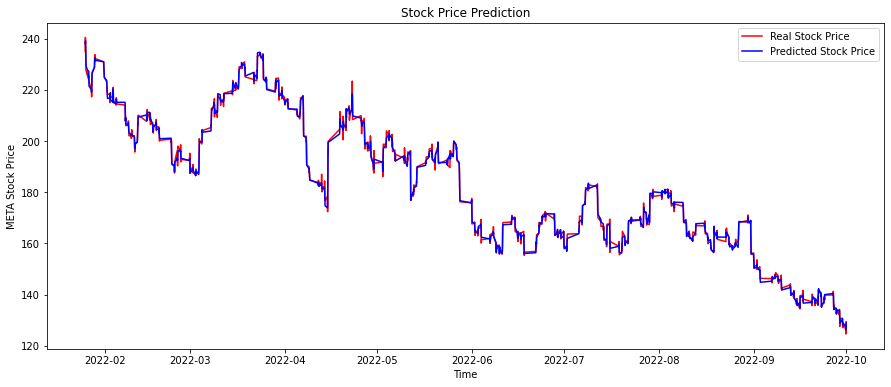

MAPE: 0.56%


In [103]:
print("Univariate LSTM - Training set")
print("="*32)
split = splits[0]
dates = df.iloc[split].index
_, _, preds = learn.get_X_preds(X[split])
visualize_predictions(dates, y[split], preds)

Univariate LSTM - Validation set


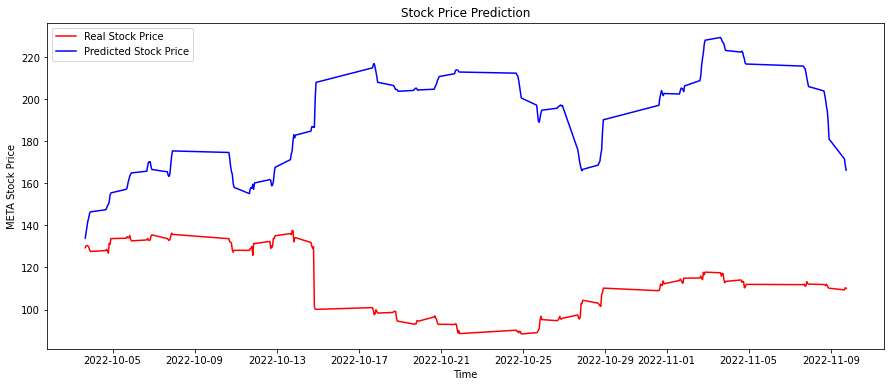

MAPE: 72.18%


In [104]:
print("Univariate LSTM - Validation set")
print("="*32)
split = splits[1]
dates = df.iloc[split].index
_, _, preds = learn.get_X_preds(X[split])
visualize_predictions(dates, y[split], preds)